In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/Users/orion/projects/RDaly2023/MCMC-fitting/Zhu+20/Zhu_Rakshit_flagged_final367.csv', 
                 header=0, usecols=[0,1,4,5,6,7,8,9])
df

,SDSS Name,z_1,Log(L_5 GHz),Log(2 keV),Log(R),alpha_r,logMBH,e_logMBH
0,000442.18+000023.3,1.008,32.09,26.91,1.74,NaN,9.281283,0.031152
1,000622.60-000424.4,1.038,34.94,27.32,4.77,-0.55,8.823198,0.059579
2,001646.54-005151.7,2.243,32.66,26.36,2.34,-0.21,9.011771,0.240900
3,001910.95+034844.6,2.022,32.91,26.54,2.44,-0.43,8.696172,0.037866
4,003054.63+045908.4,2.201,33.81,26.59,3.50,-0.41,8.688945,0.189143
...,...,...,...,...,...,...,...,...
362,222852.60-075346.6,0.638,33.12,26.83,2.91,-0.21,8.546475,0.068004
363,231156.65+015324.5,2.257,32.54,26.34,2.05,-0.33,8.784155,0.118988
364,232734.73+002234.0,1.494,33.56,26.96,2.53,-0.45,9.709295,0.111279
365,234808.62+020725.8,1.872,32.84,26.61,2.12,-0.48,9.817211,0.082521


In [3]:
df.rename(columns={'z_1':'z', 'Log(L_5 GHz)':'logR', 'Log(2 keV)': 'logX', 'Log(R)' : 'R'}, inplace=True)

In [4]:
#    R >= 2  :  RLQ
#       alpha_r <= -0.5 : FSRQ ,  alpha_r > -0.5 : SSRQ

#    R < 2  : RQQ


In [ ]:
df.loc[df['R'] >= 2]   # -- total RLQs  = 310 

In [4]:
def radiotype(n, dataframe):

    if n==1:  # FSRQ
        df_rq = dataframe.loc[(df['R'] >= 2) & (dataframe['alpha_r'] <= -0.5)]
        qtype = 'FSRQs'

    elif n==2:  # SSRQ
        df_rq = dataframe.loc[(df['R'] >= 2) & (dataframe['alpha_r'] > -0.5)]
        qtype = 'SSRQs'

    else: # RQQ
        df_rq = dataframe.loc[df['R'] < 2]
        qtype = 'RQQs'
    
    
    return df_rq, qtype

In [5]:
def statmodel_fit(xaxis, yaxis):

    xaxis = sm.add_constant(xaxis) # adding a constant
 
    model = sm.OLS(yaxis, xaxis).fit() 
    predictions = model.predict(xaxis) 
    #parameters = model.params    # fitted params
 
    print_model = model.summary()
    #print(print_model)
    
    return model
    

def log_likelihood(theta, x1, x2, y, yerr):
    m1, m2, c, log_f = theta
    model = m1*x1 + m2*x2 + c              
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


def max_likelihood_fit(x1, x2, y, yerr, m1_true, m2_true, const, f_true, name):

    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([m1_true, m2_true, const, np.log(f_true)]) + 0.1 * np.random.randn(4)
    soln = minimize(nll, initial, args=(x1, x2, y, yerr))
    m1_ml, m2_ml, const_ml, log_f_ml = soln.x

    print('Max likelihood estimates:')
    print('a = {0:.3f}'.format(m1_ml))
    print('b = {0:.3f}'.format(m2_ml))
    print('const = {0:.3f}'.format(const_ml))
    print('f = {0:.3f}'.format(np.exp(log_f_ml)))   
    
    return soln.x



In [ ]:
#                2-parameter model:    y = a.x1 + b.x2 + const
#                            y = L_r   ,   x1 = L_x   ,   x2 = M_bh   

In [ ]:
# print(fitparams)

#const    -0.895477
#logX      1.308193
#logMBH   -0.085902
#dtype: float64

In [ ]:
# Max likelihood estimates

In [8]:
rqlist = []

for m in range(1,4):
    
    dfrq, title = radiotype(m, df)
    x = dfrq[['logX','logMBH']]
    y = dfrq['logR']
    
    print('\n', len(dfrq.index), title)
    mod = statmodel_fit(x, y)
    fitparams = mod.params  

    #print(mod)
    #print(fitparams)  -> array
    
    #initial guesses = OLP fit values 
    ols_m1 = fitparams[1]
    ols_m2 = fitparams[2]
    ols_const = fitparams[0]
    ols_f = 0.500   # random guess 
    
    xX = x.to_numpy()[:,0]   
    xM = x.to_numpy()[:,1]
    
    dfrq['logX_err'] = dfrq['logX'].std()   # 1sigma as error bar
    yerr = np.sqrt(dfrq['logX_err']**2 + dfrq['e_logMBH']**2)
    
    soln = max_likelihood_fit(xX, xM, y, yerr, ols_m1, ols_m2, ols_const, ols_f, title)
    
    rqlist.append(soln)
    



 140 FSRQs
Max likelihood estimates:
a = 1.309
b = -0.081
const = -0.975
f = 0.011

 167 SSRQs
Max likelihood estimates:
a = 1.248
b = -0.276
const = 2.272
f = 0.000

 57 RQQs
Max likelihood estimates:
a = 0.310
b = 0.298
const = 21.196
f = 0.000


In [11]:

def mcmc_fit(x1, x2, y, yerr, rq_params):
    
    
    # max likelihood estimates
    m1_true, m2_true, const, f_true = rq_params
    soln = m1_true, m2_true, const, f_true
    
    pos = soln + 0.05 * np.random.randn(32, 4)
    nwalkers, ndim = pos.shape

    print('walkers=', nwalkers, 'dimensions=', ndim)
    
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x1, x2, y, yerr)
    )

    sampler.run_mcmc(pos, 500, progress=True);   #the colon prevents hidden print command apparently
    
    fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
    samples = sampler.get_chain()
    labels = ['a', 'b', 'c', 'log(f)']
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    
    #reset and re-run
    sampler.reset()
    sampler.run_mcmc(pos, 5000, progress=True);


    fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
    samples = sampler.get_chain()
    labels = ['a', 'b', 'c', 'log(f)']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    
    tau = sampler.get_autocorr_time()
    print('auto correlation time=', tau)
    
    flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
    #print(flat_samples.shape)
    
    fig = corner.corner(
    flat_samples, labels=labels, truths=[m1_true, m2_true, const, np.log(f_true)] #10**f_true]    # antilog f
    ) 
    
    inds = np.random.randint(len(flat_samples), size=100)
    for ind in inds:
        sample = flat_samples[ind]
    #print(sample)
    
    
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
    


In [21]:
print(rqlist)

[array([ 1.30944711, -0.08139424, -0.97509487, -4.49292042]), array([  1.24754237,  -0.27560956,   2.27176619, -13.08346533]), array([  0.30950606,   0.29846061,  21.19584013, -12.46762586])]


In [25]:
# use max-likelihood fit results to predict the range of params

def log_prior_fsrq(theta):
    m1, m2, c, log_f = theta
    if -5.0 < m1 < 5.0 and -5.0 < m2 < 5.0 and -3.0 < c < 2.0 and -5.0 < log_f < 1.0:
        return 0.0
    return -np.inf


def log_prior_ssrq(theta):
    m1, m2, c, log_f = theta
    if -5.0 < m1 < 5.0 and -5.0 < m2 < 5.0 and -5.0 < c < 5.0 and -20.0 < log_f < 1.0:
        return 0.0
    return -np.inf
    

def log_prior_rqq(theta):
    m1, m2, c, log_f = theta
    if -5.0 < m1 < 5.0 and -5.0 < m2 < 5.0 and -5.0 < c < 30.0 and -20.0 < log_f < 1.0:
        return 0.0
    return -np.inf


FSRQs: [ 1.30944711 -0.08139424 -0.97509487 -4.49292042]
walkers= 32 dimensions= 4


100%|████████████████████████████████████████████| 5000/5000 [01:18<00:00, 63.84it/s]


auto correlation time= [68.1027637  62.17804449 74.73700896 63.07285215]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

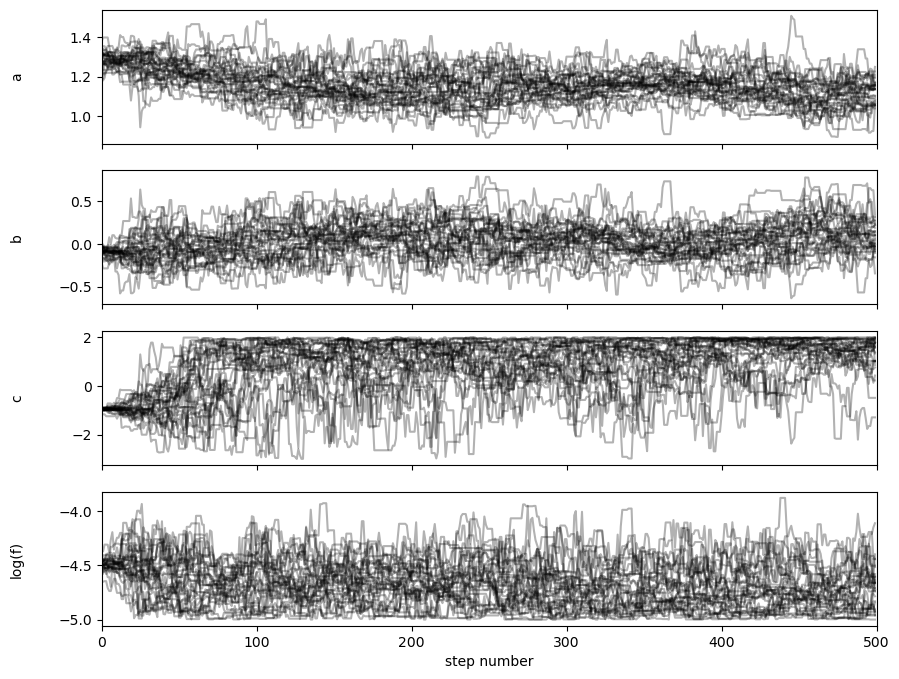

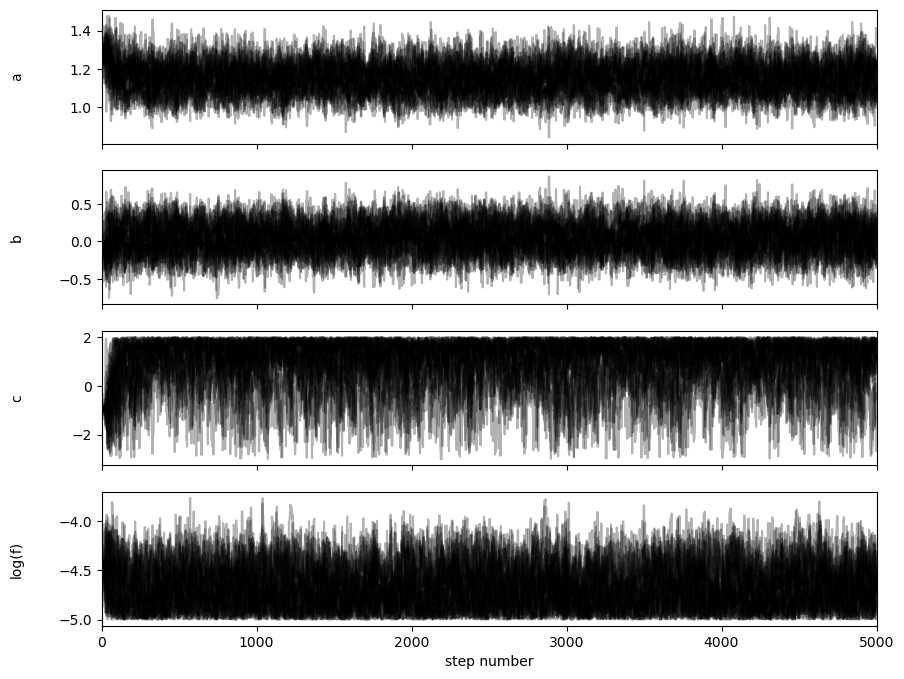

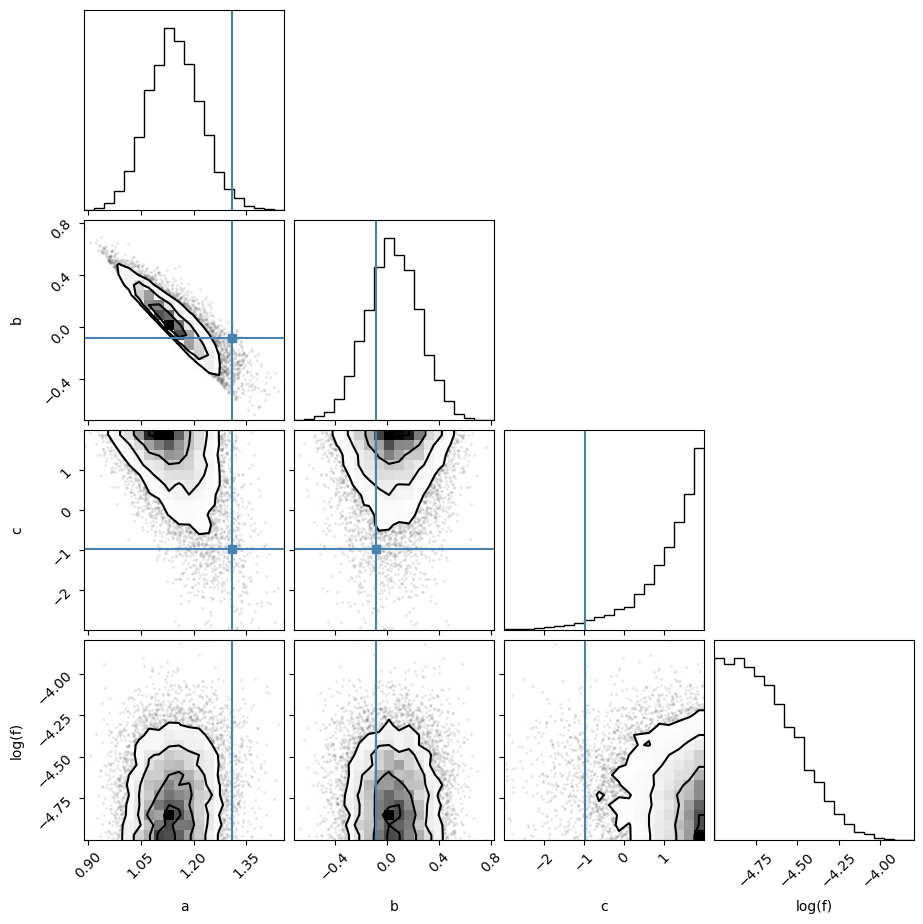

In [20]:
# MCMC fit & error estimation
# m -> 0 to 2


def log_probability(theta, x1, x2, y, yerr):
    
    lp = log_prior_fsrq(theta)  
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr)


print('FSRQs:', rqlist[0])
mcmc_fit(xX, xM, y, yerr, rqlist[0])


SSRQs: [  1.24754237  -0.27560956   2.27176619 -13.08346533]
walkers= 32 dimensions= 4


100%|████████████████████████████████████████████| 5000/5000 [01:18<00:00, 63.95it/s]


auto correlation time= [68.35293647 59.50650853 71.85787612 62.34637533]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

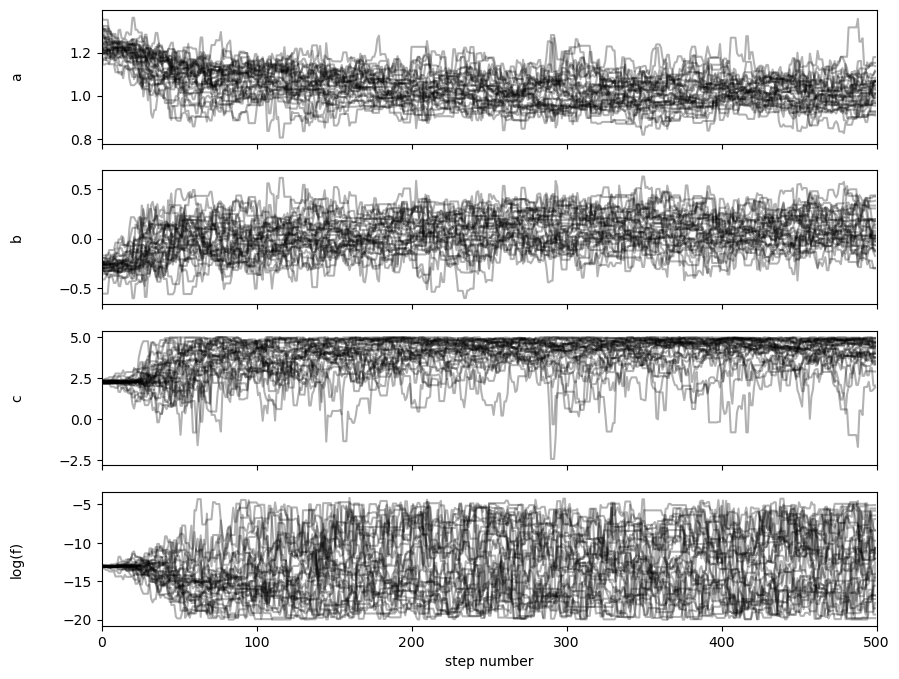

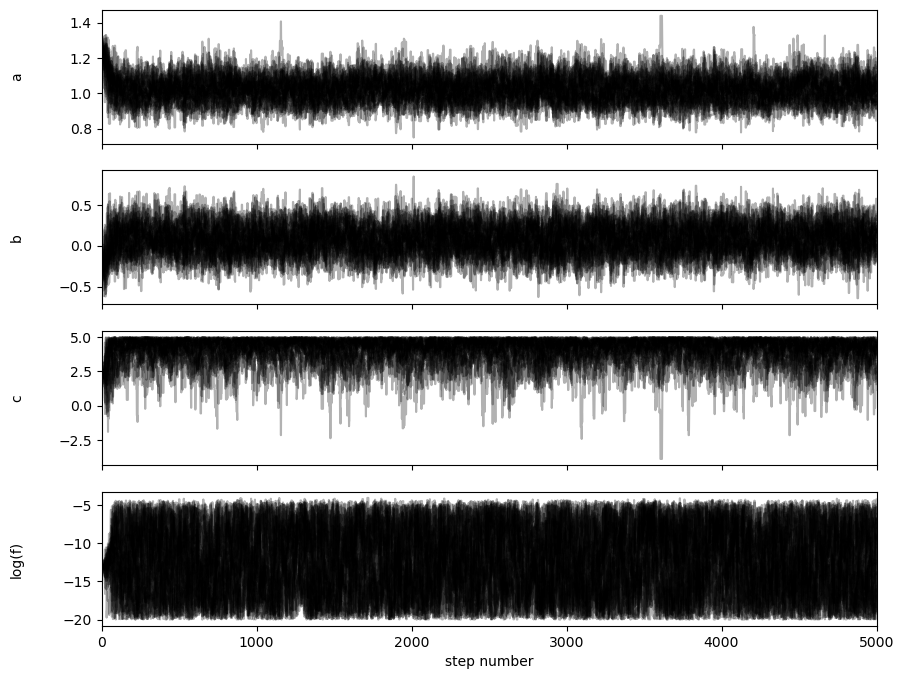

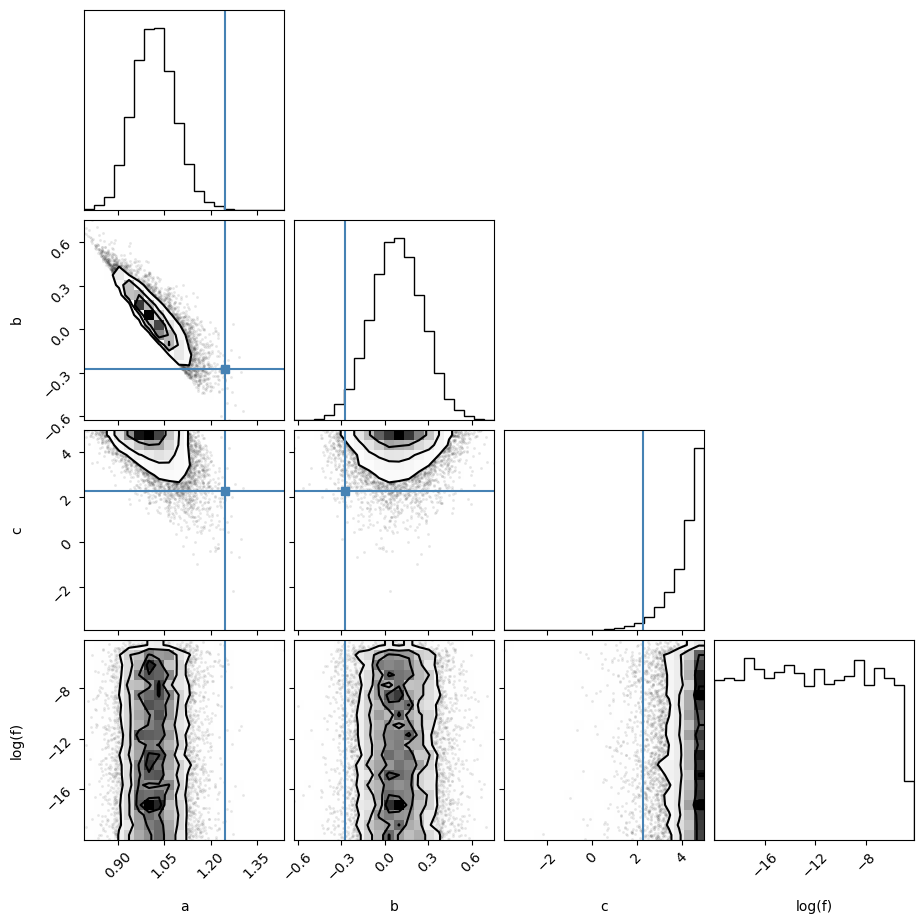

In [24]:
def log_probability(theta, x1, x2, y, yerr):
    
    lp = log_prior_ssrq(theta)  
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr)


print('SSRQs:', rqlist[1])
mcmc_fit(xX, xM, y, yerr, rqlist[1])


RQQs: [  0.30950606   0.29846061  21.19584013 -12.46762586]
walkers= 32 dimensions= 4


100%|████████████████████████████████████████████| 5000/5000 [01:24<00:00, 59.47it/s]


auto correlation time= [50.16395968 45.5108047  49.45983566 55.44139865]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

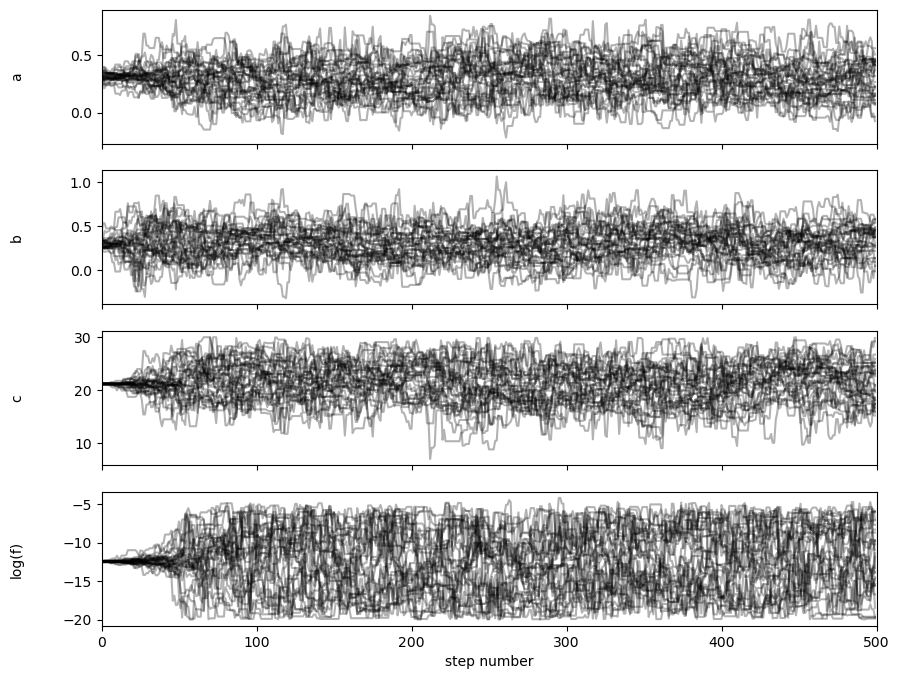

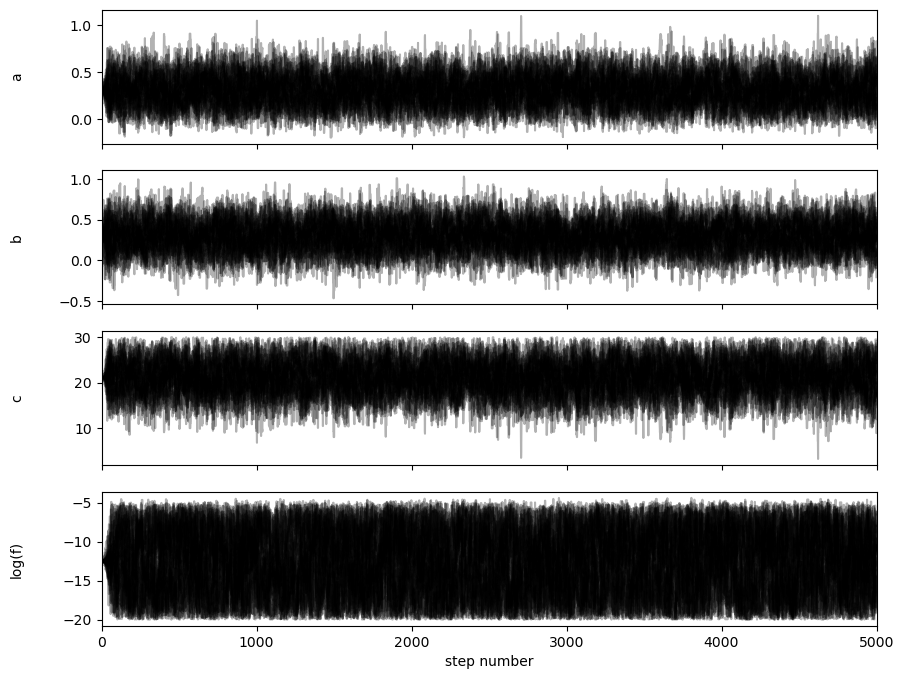

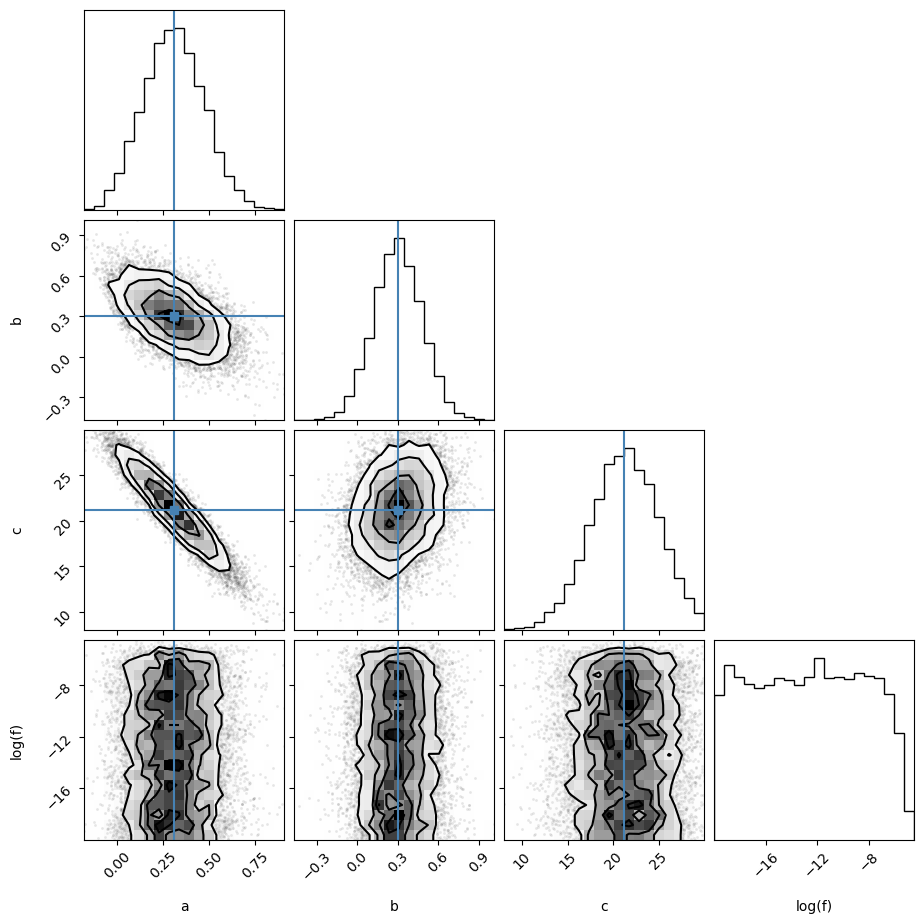

In [27]:
def log_probability(theta, x1, x2, y, yerr):
    
    lp = log_prior_rqq(theta)  
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr)


print('RQQs:', rqlist[2])
mcmc_fit(xX, xM, y, yerr, rqlist[2])
